In [5]:
from __future__ import print_function, division

import os
import sys
from torch.utils.data import DataLoader
from easydict import EasyDict as edict
import json
import torchvision
import torch
import copy
from tqdm import tqdm
import pandas as pd
from sklearn import metrics
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
import time
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.manifold import TSNE
import seaborn as sns
from torch.nn import init
import itertools
import random

Matplotlib is building the font cache; this may take a moment.


In [5]:
transform = {
    'train':
    transforms.Compose(
        [
#             transforms.ToPILImage(),
#             transforms.Resize((256,256)),
            transforms.RandomResizedCrop((256),scale=(0.9,1)),
            transforms.RandomHorizontalFlip(),
#             transforms.RandomCrop(32, padding=4),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True),
        ]),
    'val':
    transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True),
    ])
}

In [7]:
mimic = datasets.ImageFolder('/home/diwenxu2/data_AP/more/mimic', transform=transform['val'])
chexpert = datasets.ImageFolder('/home/diwenxu2/data_AP/train/chexpert256', transform=transform['val'])
url = '/home/diwenxu2/dataset_gan/chexpert_16k_seed8_classifier_AP_1024.ckpt'

In [8]:
n=1024

In [9]:
class Model(nn.Module):
    def __init__(self,n):
        super().__init__()
        self.res = models.resnet152(pretrained=True)
        num_ftrs = self.res.fc.in_features
        self.res.fc = nn.Linear(num_ftrs, n)

        self.linear = nn.Linear(n, 1)
        
        self.norm = nn.LayerNorm(n)
        
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, x):
        x = self.leaky_relu(self.res(x))
        x = self.leaky_relu(self.norm(x))
        x = self.leaky_relu(self.linear(x))
        return x

class Features(nn.Module):
    def __init__(self,n):
        super().__init__()
        self.res = models.resnet152(pretrained=True)
        num_ftrs = self.res.fc.in_features
        self.res.fc = nn.Linear(num_ftrs, n)

        self.linear = nn.Linear(n, 1)
        
        self.norm = nn.LayerNorm(n)
        
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, x):
        x = self.leaky_relu(self.res(x))
        x = self.leaky_relu(self.norm(x))
#         x = self.leaky_relu(self.linear(x))
        return x

In [10]:
def get_features(dataset,n,batch):
    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'

    # initialize our implementation of ResNet
    model_1 = Features(n)
    model_1.load_state_dict(torch.load(url))
    model_1 = model_1.to(device)
    model_1.eval()
    
    model_2 = Model(n)
    model_2.load_state_dict(torch.load(url))
    model_2 = model_2.to(device)
    model_2.eval()

    # read the dataset and initialize the data loader
    torch.manual_seed(31)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch, shuffle=True)

    # we'll store the features as NumPy array of size num_images x feature_size
    features = None

    # we'll also store the image labels and paths to visualize them later
    labels = []
    preds = []

    for batch in tqdm(dataloader, desc='Running the model inference'):
        images = batch[0].to(device)
        labels += batch[1]
        outputs = model_2(images)
        preds += (torch.sigmoid(outputs)>0.5).cpu()

        with torch.no_grad():
            output = model_1.forward(images)

        current_features = output.cpu().numpy()
        if features is not None:
            features = np.concatenate((features, current_features))
        else:
            features = current_features

    return features, labels, preds

In [11]:
features_mimic, labels_mimic, preds_mimic = get_features(mimic,n,batch=16)
features_chexpert,labels_chexpert,preds_chexpert = get_features(chexpert,n,batch = 16)

Running the model inference:   0%|          | 0/513 [00:00<?, ?it/s]/home/diwenxu2/anaconda3/envs/dw/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Running the model inference: 100%|██████████| 1250/1250 [07:23<00:00,  2.82it/s]


In [12]:
acc_m = [1 if i==j else 0 for i,j in zip(labels_mimic,preds_mimic)]
acc_c = [1 if i==j else 0 for i,j in zip(labels_chexpert,preds_chexpert)]
print(sum(acc_m)/len(acc_m))
print(sum(acc_c)/len(acc_c))

0.6689857195166605
0.8654


In [13]:
len(features_mimic),len(features_chexpert)

(8193, 20000)

In [14]:
train_mimic = DataLoader(features_mimic[:8000], batch_size=16, shuffle=True)
train_chexpert = DataLoader(features_chexpert[:8000],batch_size=16,shuffle=True)

In [15]:
class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block
        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.
        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not
        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out

In [16]:
class ResnetGenerator(nn.Module):
    """Resnet-based generator that consists of Resnet blocks between a few downsampling/upsampling operations.
    We adapt Torch code and idea from Justin Johnson's neural style transfer project(https://github.com/jcjohnson/fast-neural-style)
    """

    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, padding_type='reflect'):
        """Construct a Resnet-based generator
        Parameters:
            input_nc (int)      -- the number of channels in input images
            output_nc (int)     -- the number of channels in output images
            ngf (int)           -- the number of filters in the last conv layer
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers
            n_blocks (int)      -- the number of ResNet blocks
            padding_type (str)  -- the name of padding layer in conv layers: reflect | replicate | zero
        """
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks

            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        """Standard forward"""
        return self.model(input)

In [17]:
def init_weights(net, init_type='normal', init_gain=0.02):
    """Initialize network weights.
    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.
    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)

In [18]:
class NLayerDiscriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(NLayerDiscriminator, self).__init__()
        use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)

In [19]:
class GANLoss(nn.Module):
    """Define different GAN objectives.
    The GANLoss class abstracts away the need to create the target label tensor
    that has the same size as the input.
    """

    def __init__(self, gan_mode, target_real_label=1.0, target_fake_label=0.0):
        """ Initialize the GANLoss class.
        Parameters:
            gan_mode (str) - - the type of GAN objective. It currently supports vanilla, lsgan, and wgangp.
            target_real_label (bool) - - label for a real image
            target_fake_label (bool) - - label of a fake image
        Note: Do not use sigmoid as the last layer of Discriminator.
        LSGAN needs no sigmoid. vanilla GANs will handle it with BCEWithLogitsLoss.
        """
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        self.gan_mode = gan_mode
        if gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
        elif gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode in ['wgangp']:
            self.loss = None
        else:
            raise NotImplementedError('gan mode %s not implemented' % gan_mode)

    def get_target_tensor(self, prediction, target_is_real):
        """Create label tensors with the same size as the input.
        Parameters:
            prediction (tensor) - - tpyically the prediction from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images
        Returns:
            A label tensor filled with ground truth label, and with the size of the input
        """

        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(prediction)

    def __call__(self, prediction, target_is_real):
        """Calculate loss given Discriminator's output and grount truth labels.
        Parameters:
            prediction (tensor) - - tpyically the prediction output from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images
        Returns:
            the calculated loss.
        """
        if self.gan_mode in ['lsgan', 'vanilla']:
            target_tensor = self.get_target_tensor(prediction, target_is_real)
            loss = self.loss(prediction, target_tensor)
        elif self.gan_mode == 'wgangp':
            if target_is_real:
                loss = -prediction.mean()
            else:
                loss = prediction.mean()
        return loss

In [20]:
class ImagePool():
    """This class implements an image buffer that stores previously generated images.
    This buffer enables us to update discriminators using a history of generated images
    rather than the ones produced by the latest generators.
    """

    def __init__(self, pool_size):
        """Initialize the ImagePool class
        Parameters:
            pool_size (int) -- the size of image buffer, if pool_size=0, no buffer will be created
        """
        self.pool_size = pool_size
        if self.pool_size > 0:  # create an empty pool
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        """Return an image from the pool.
        Parameters:
            images: the latest generated images from the generator
        Returns images from the buffer.
        By 50/100, the buffer will return input images.
        By 50/100, the buffer will return images previously stored in the buffer,
        and insert the current images to the buffer.
        """
        if self.pool_size == 0:  # if the buffer size is 0, do nothing
            return images
        return_images = []
        for image in images:
            image = torch.unsqueeze(image.data, 0)
            if self.num_imgs < self.pool_size:   # if the buffer is not full; keep inserting current images to the buffer
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:  # by 50% chance, the buffer will return a previously stored image, and insert the current image into the buffer
                    random_id = random.randint(0, self.pool_size - 1)  # randint is inclusive
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:       # by another 50% chance, the buffer will return the current image
                    return_images.append(image)
        return_images = torch.cat(return_images, 0)   # collect all the images and return
        return return_images

In [21]:
# n=1024, gan_mode='lsgan', lr='0.0002', beta = 0.5
class cycleGAN(nn.Module):
    def __init__(self,gan_mode,lr,beta):
        super().__init__()
        self.G_A = ResnetGenerator(1,1)
        self.G_B = ResnetGenerator(1,1)
        self.D_A = NLayerDiscriminator(1)
        self.D_B = NLayerDiscriminator(1)
        self.criterionGAN = GANLoss(gan_mode).cuda()
        self.criterionCycle = nn.L1Loss()
        self.criterionIdt = nn.L1Loss()
        self.fake_A_pool = ImagePool(1000)
        self.fake_B_pool = ImagePool(1000)
        self.optimizer_G = torch.optim.Adam(itertools.chain(self.G_A.parameters(), self.G_B.parameters()), lr=lr, betas=(beta, 0.999))
        self.optimizer_D = torch.optim.Adam(itertools.chain(self.D_A.parameters(), self.D_B.parameters()), lr=lr, betas=(beta, 0.999))
        
    def forward(self):
        self.fake_B = self.G_A(self.real_A)
        self.rec_A = self.G_B(self.fake_B)
        self.fake_A = self.G_B(self.real_B)
        self.rec_B = self.G_A(self.fake_A)
        
    def test(self,real,A2B):
        batch = real.shape[0]
        real = real.reshape(batch,1,32,32)
        if A2B:
            pred = self.G_A(real)
        else:
            pred = self.G_B(real)
        pred = pred.reshape(batch,-1)
        return pred
        
    def set_input(self,real_A,real_B):
        batch = real_A.shape[0]
        self.real_A = real_A.reshape(batch,1,32,32).cuda()
        self.real_B = real_B.reshape(batch,1,32,32).cuda()
        
    def backward_D_basic(self,D,real,fake):
        pred_real = D(real)
        loss_D_real = self.criterionGAN(pred_real,True)
        
        pred_fake = D(fake.detach())
        loss_D_fake = self.criterionGAN(pred_fake, False)
        
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        loss_D.backward()
        return loss_D
    
    def backward_D_A(self):
        """Calculate GAN loss for discriminator D_A"""
        fake_B = self.fake_B_pool.query(self.fake_B)
        self.loss_D_A = self.backward_D_basic(self.D_A, self.real_B, fake_B)

    def backward_D_B(self):
        """Calculate GAN loss for discriminator D_B"""
        fake_A = self.fake_A_pool.query(self.fake_A)
        self.loss_D_B = self.backward_D_basic(self.D_B, self.real_A, fake_A)

    def backward_G(self):
        """Calculate the loss for generators G_A and G_B"""
        lambda_idt = 0.5
        lambda_A = 0.5
        lambda_B = 0.5
        # Identity loss
        if lambda_idt > 0:
            # G_A should be identity if real_B is fed: ||G_A(B) - B||
            self.idt_A = self.G_A(self.real_B)
            self.loss_idt_A = self.criterionIdt(self.idt_A, self.real_B) * lambda_B * lambda_idt
            # G_B should be identity if real_A is fed: ||G_B(A) - A||
            self.idt_B = self.G_B(self.real_A)
            self.loss_idt_B = self.criterionIdt(self.idt_B, self.real_A) * lambda_A * lambda_idt
        else:
            self.loss_idt_A = 0
            self.loss_idt_B = 0

        # GAN loss D_A(G_A(A))
        self.loss_G_A = self.criterionGAN(self.D_A(self.fake_B), True)
        # GAN loss D_B(G_B(B))
        self.loss_G_B = self.criterionGAN(self.D_B(self.fake_A), True)
        # Forward cycle loss || G_B(G_A(A)) - A||
        self.loss_cycle_A = self.criterionCycle(self.rec_A, self.real_A) * lambda_A
        # Backward cycle loss || G_A(G_B(B)) - B||
        self.loss_cycle_B = self.criterionCycle(self.rec_B, self.real_B) * lambda_B
        # combined loss and calculate gradients
        self.loss_G = self.loss_G_A + self.loss_G_B + self.loss_cycle_A + self.loss_cycle_B + self.loss_idt_A + self.loss_idt_B
        self.loss_G.backward()
        
    def optimize_parameters(self):
        """Calculate losses, gradients, and update network weights; called in every training iteration"""
        # forward
        self.forward()      # compute fake images and reconstruction images.
        # G_A and G_B
#         self.set_requires_grad([self.D_A, self.D_B], False)  # Ds require no gradients when optimizing Gs
        self.optimizer_G.zero_grad()  # set G_A and G_B's gradients to zero
        self.backward_G()             # calculate gradients for G_A and G_B
        self.optimizer_G.step()       # update G_A and G_B's weights
        # D_A and D_B
#         self.set_requires_grad([self.D_A, self.D_B], True)
        self.optimizer_D.zero_grad()   # set D_A and D_B's gradients to zero
        self.backward_D_A()      # calculate gradients for D_A
        self.backward_D_B()      # calculate graidents for D_B
        self.optimizer_D.step()  # update D_A and D_B's weights
        return self.loss_G,self.loss_D_B+self.loss_D_A

In [22]:
model = cycleGAN('lsgan',0.0002,0.5)
init_weights(model.G_A)
init_weights(model.G_B)
model.cuda()

initialize network with normal
initialize network with normal


cycleGAN(
  (G_A): ResnetGenerator(
    (model): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), bias=False)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): ResnetBlock(
        (conv_block): Sequential(
          (0): ReflectionPad2d((1, 1, 1, 1))
          (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

499it [01:21,  6.08it/s]

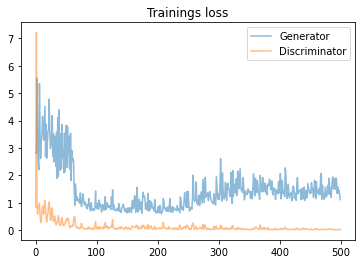

500it [01:24,  5.89it/s]
499it [01:23,  6.47it/s]

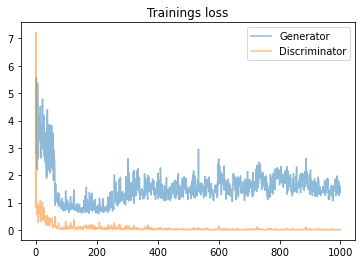

500it [01:25,  5.83it/s]
499it [01:22,  5.96it/s]

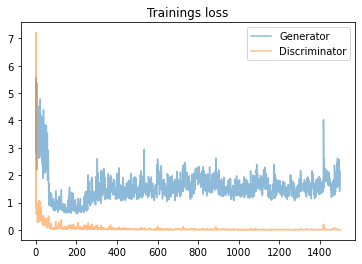

500it [01:25,  5.84it/s]
499it [01:22,  5.89it/s]

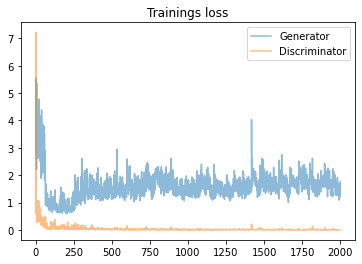

500it [01:29,  5.60it/s]
499it [01:22,  6.42it/s]

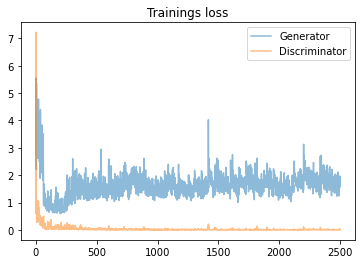

500it [01:25,  5.85it/s]
499it [01:19,  6.56it/s]

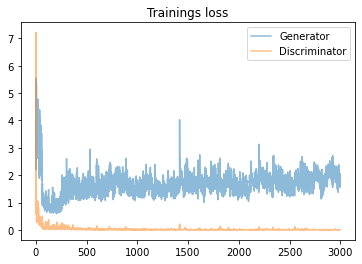

500it [01:22,  6.03it/s]
499it [01:21,  6.06it/s]

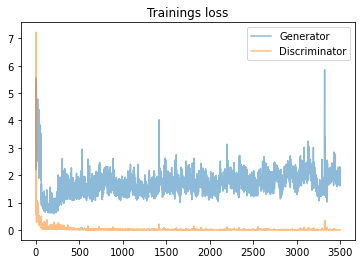

500it [01:27,  5.74it/s]
499it [01:19,  6.01it/s]

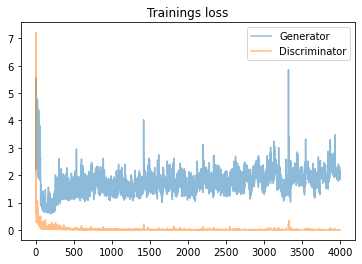

500it [01:25,  5.84it/s]
499it [01:18,  6.96it/s]

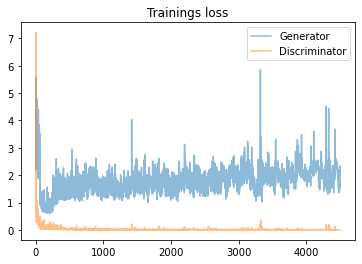

500it [01:20,  6.19it/s]
499it [01:21,  6.49it/s]

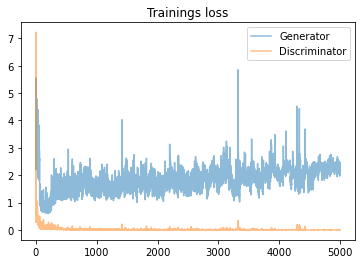

500it [01:24,  5.90it/s]


In [23]:
i = 0
losses_G = []
losses_D = []
model.train()
for epochs in range(10):
    for real_A,real_B in tqdm(zip(train_mimic,train_chexpert)):
        i+=1
        model.set_input(real_A,real_B)
        loss_G,loss_D = model.optimize_parameters()
        losses_G.append(loss_G)
        losses_D.append(loss_D)
        if i%500 == 0:
            torch.save(model.state_dict(),'cyclegan/iter_mimicA_chexB_'+str(i)+'_cycleganweights.pth')
            plt.plot(losses_G, label="Generator", alpha=0.5)
            plt.plot(losses_D, label="Discriminator", alpha=0.5)
            plt.title("Trainings loss")
            plt.legend()
            plt.show()
torch.save(model.state_dict(),'latest'+'_mimicA2chexB_'+'cycleganweights.pth')

In [24]:
torch.save(model.state_dict(),'latest'+'_mimicA2chexB_'+'cycleganweights.pth')

In [ ]:
# class Discriminator(nn.Module):
#     def __init__(self, image_size,n):
#         super().__init__()
#         input_features = n
    
#         # Define hidden linear layers
#         self.hcl1 = nn.Linear(input_features, 1024)
# #         self.hcl2 = nn.Linear(1024, 512)
#         self.conv = nn.Conv1d(32,32,1, stride=2)
# #         self.hcl3 = nn.Linear(512, 256)
#         self.out = nn.Linear(256, 1)
#         self.maxpool = nn.MaxPool1d(2, stride=2)
#         # Activation function
#         self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
  
#     def forward(self, x):
#         batch = x.shape[0]
#         x = self.leaky_relu(self.hcl1(x))
# #         x = self.leaky_relu(self.hcl2(x))
#         x = x.reshape(batch,32,32)
# #         x = self.leaky_relu(self.hcl3(x))
#         x = self.leaky_relu(self.conv(x)) 
#         x = self.leaky_relu(self.maxpool(x))
#         x = x.reshape(batch,-1)
#         x = torch.sigmoid(self.out(x))
#         return x

In [ ]:
# def linear_block(in_features, out_features, batch_norm=True):
#     layers = []
#     if batch_norm:
#         linear_layer = nn.Linear(in_features, out_features, bias=False)
#         batch_norm = nn.BatchNorm1d(out_features)
#         layers = [linear_layer, batch_norm]
#     else:
#         layers.append(nn.Linear(in_features, out_features))
#     return nn.Sequential(*layers)

In [ ]:
# class Generator(nn.Module):
#     def __init__(self, input_features, n):
#         super().__init__()
#         output_features = n
    
#         # Define hidden linear layers
#         self.hcl1 = linear_block(input_features, 256)
#         self.hcl0 = linear_block(128, 256)
#         self.hcl2 = linear_block(256, 512)
#         self.hcl3 = linear_block(512, 1024)
#         self.conv = nn.Conv1d(16, 16, 1, stride=2)
#         self.maxpool = nn.MaxPool1d(2, stride=2)

#         self.output = linear_block(1024, output_features)
    
#         # Activation function
#         self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
    
#     def forward(self, x):
#         batch = x.shape[0]
#         x = self.leaky_relu(self.hcl1(x))
#         x = x.reshape(batch,16,16)
#         x = self.leaky_relu(self.conv(x))
#         x = x.reshape(batch,-1)
#         x = self.leaky_relu(self.hcl0(x))
#         x = self.leaky_relu(self.hcl2(x))
#         x = x.reshape(batch,32,16)
#         x = self.leaky_relu(self.maxpool(x))
#         x = x.reshape(batch,-1)
#         x = self.leaky_relu(self.hcl2(x))
#         x = self.leaky_relu(self.hcl3(x))
#         x = torch.tanh(self.output(x))
#         return x

In [ ]:
# D = Discriminator(n,n)
# G = Generator(n,n)
# if torch.cuda.is_available():
#     G = G.cuda()
#     D = D.cuda()

In [ ]:
# def real_loss(predictions, smooth=False):
#     batch_size = predictions.shape[0]
#     labels = torch.ones(batch_size)
#     # Smooth labels for discriminator to weaken learning
#     if smooth:
#         labels = labels * 0.9
#     # We use the binary cross entropy loss | Model has a sigmoid function
#     criterion = nn.BCELoss()
#     # Move models to GPU if available
#     if torch.cuda.is_available():
#         labels = labels.cuda()
#         criterion = criterion.cuda()
#     loss = criterion(predictions.squeeze(), labels)
#     return loss

# def fake_loss(predictions):
#     batch_size = predictions.shape[0]
#     labels = torch.zeros(batch_size)
#     criterion = nn.BCELoss()
#     # Move models to GPU if available
#     if torch.cuda.is_available():
#         labels = labels.cuda()
#         criterion = criterion.cuda()
#     loss = criterion(predictions.squeeze(), labels)
#     return loss

In [ ]:
# def random_vector(batch_size, length):
#     # Sample from a Gaussian distribution
#     z_vec = torch.randn(batch_size, length).float()
#     if torch.cuda.is_available():
#         z_vec = z_vec.cuda()
#     return z_vec

In [ ]:
# lr = 0.0002
# beta1 = 0.5
# beta2 = 0.999

# d_optimizer = optim.Adam(D.parameters(), lr=lr, betas=[beta1, beta2])
# g_optimizer = optim.Adam(G.parameters(), lr=lr, betas=[beta1, beta2])

In [ ]:
# def train_discriminator(generator, discriminator, optimizer, real_data, batch_size, z_size):
    
#     # Reset gradients and set model to training mode
#     optimizer.zero_grad()
#     discriminator.train()
    
#     # Train on real data
#     real_data_logits = discriminator.forward(real_data)
#     loss_real = real_loss(real_data_logits, smooth=True)
#     # Generate fake data
#     z_vec = random_vector(batch_size, z_size)
#     fake_data = generator.forward(z_vec)
#     # Train on fake data
#     fake_data_logits = discriminator.forward(fake_data)
#     loss_fake = fake_loss(fake_data_logits)
#     # Calculate total loss
#     total_loss = loss_real + loss_fake
#     total_loss.backward()
#     optimizer.step()
    
#     return total_loss

In [ ]:
# def train_generator(generator, discriminator, optimizer, batch_size, z_size):
#     # Reset gradients and set model to training mode
#     optimizer.zero_grad()
#     generator.train()
#     # Generate fake data
#     z_vec = random_vector(batch_size, z_size)
#     fake_data = generator.forward(z_vec)
#     # Train generator with output of discriminator
#     discriminator_logits = discriminator.forward(fake_data)
#     # Reverse labels
#     loss = real_loss(discriminator_logits)
#     loss.backward()
#     optimizer.step()
#     return loss

In [ ]:
# epochs = 201
# # After how many batches should generated sample images be shown?
# print_every = 200
# # How many images should be shown?
# sample_size = 8
# # After how many epochs should the loss be plotted?
# plot_every = 5
# # Create some sample noise
# sample_noise = random_vector(sample_size, n)
# #-------------------------

# # Keep track of losses
# d_losses = []
# g_losses = []

# for e in range(epochs):
#     for batch_i, images in enumerate(train_loader):
#         batch_size = images.shape[0]
#         # Move images to GPU if available
#         if torch.cuda.is_available():
#             images = images.cuda()
#         # Train discriminator
#         d_loss = train_discriminator(G, D, d_optimizer, images, batch_size, n)
#         # Train generator
#         g_loss = train_generator(G, D, g_optimizer, batch_size, n)
        
#         # Keep track of losses
#         d_losses.append(d_loss)
#         g_losses.append(g_loss)
        
#         # Print some sample pictures
#         if (batch_i % print_every == 0):
#             print("Epoch: {}, Batch: {}, D-Loss: {}, G-Loss: {}".format(e, batch_i, d_loss, g_loss))
            
#     if (e % plot_every == 0):
#         # Print losses
#         plt.plot(d_losses, label="Discriminator", alpha=0.5)
#         plt.plot(g_losses, label="Generator", alpha=0.5)
#         plt.title("Trainings loss")
#         plt.legend()
#         plt.show()

In [ ]:
torch.save(G.state_dict(), 'LinearGANGenator.ckpt')

In [17]:
cyclegan = cycleGAN('lsgan',0.0002,0.5)
cyclegan.load_state_dict(torch.load('latest_cycleganweights.pth'))

<All keys matched successfully>

In [65]:
class finalModel(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.res = Features(n)
        self.res.load_state_dict(torch.load(url))

        self.model = cycleGAN('lsgan',0.0002,0.5)
        self.model.load_state_dict(torch.load('latest_mimicA2chexB_cycleganweights.pth'))

        self.linear = nn.Linear(n, 1)
        
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, x):
        x = self.leaky_relu(self.res(x))
        x = self.leaky_relu(self.model.test(x,0))
        x = self.leaky_relu(self.linear(x))
        return torch.sigmoid(x)

In [66]:
model = finalModel(n)
model.cuda()
model.eval()

finalModel(
  (res): Features(
    (res): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True

In [67]:
test_loader = DataLoader(mimic, batch_size=20, shuffle=True)

In [68]:
preds = []
real = []
for image,labels in tqdm(test_loader):
    image = image.cuda()
    
    output = model(image)
    preds += (output>0.5)
    real += labels

100%|██████████| 410/410 [00:30<00:00, 13.23it/s]


In [69]:
evaluation = [1 if i==j else 0 for i,j in zip(preds,real)]
sum(evaluation)/len(evaluation)

0.4989625289881606

In [79]:
mimic_loader = DataLoader(features_mimic, batch_size=20, shuffle=False)
chexpert_loader = DataLoader(features_chexpert, batch_size=20, shuffle=False)

In [71]:
converted = []
for mimics in tqdm(mimic_loader):
#     mimics = mimics.cuda()
    converted_mimic = cyclegan.test(mimics,0)
    for i in converted_mimic:
        converted.append(i.cpu().detach().numpy().tolist())

100%|██████████| 410/410 [00:34<00:00, 11.87it/s]


In [80]:
converted_chexpert = []
for chex in tqdm(chexpert_loader):
#     mimics = mimics.cuda()
    converted_chex = cyclegan.test(chex,1)
    for i in converted_chex:
        converted_chexpert.append(i.cpu().detach().numpy().tolist())

100%|██████████| 1000/1000 [01:23<00:00, 12.03it/s]


In [72]:
tsne = TSNE(n_components=2,init='pca')
def getxy(features):
    result = tsne.fit_transform(features)
    tx = result[:, 0]
    ty = result[:, 1]
    return tx,ty

In [81]:
colors_per_class = {
    1 : [[254, 202, 87], [10, 189, 227],[234,135,22]],
    0 : [[255, 107, 107],[255, 159, 243],[98,77,35]],
}
label_convert = {
    1:'Car',
    0:'Normal'
}

In [82]:
t = 1600
tx_c,ty_c = getxy(features_chexpert[:t])
tx_m,ty_m = getxy(features_mimic[:t])
tx_co,ty_co = getxy(converted_chexpert[:t])

from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=7)

x1 = tx_c
x2 = ty_c
y = np.array(preds_chexpert[:t]).astype(int)

X = np.column_stack((x1,x2))

clf.fit(X,y)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


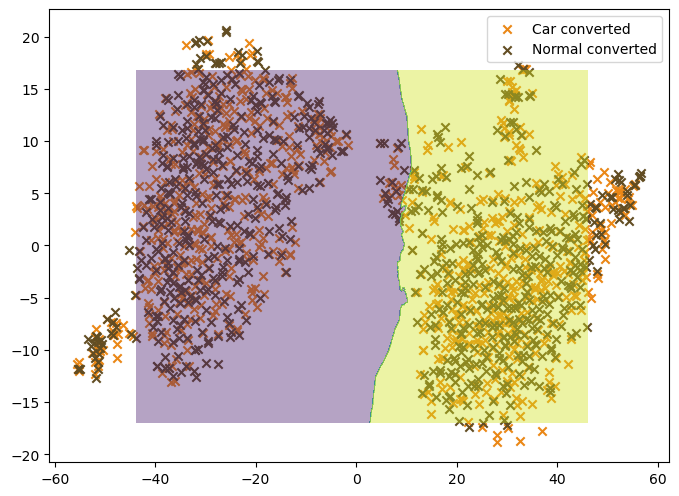

In [83]:
fig = plt.figure(figsize=[8,6],dpi=100)
ax = fig.add_subplot(111)

for label in colors_per_class:    

#     indices_c = [i for i, l in enumerate(labels_chexpert[:t]) if l == label]
#     current_tx_c = np.take(tx_c, indices_c)
#     current_ty_c = np.take(ty_c, indices_c)
#     color_c = np.array(colors_per_class[label][0], dtype=np.float) / 255
#     ax.scatter(current_tx_c, current_ty_c, c=color_c, label=label_convert[label]+' chexpert',marker='o')
    
#     indices_m = [i for i, l in enumerate(labels_mimic[:t]) if l == label]
#     current_tx_m = np.take(tx_m, indices_m)
#     current_ty_m = np.take(ty_m, indices_m)
#     color_m = np.array(colors_per_class[label][1], dtype=np.float) / 255
#     ax.scatter(current_tx_m, current_ty_m, c=color_m, label=label_convert[label]+' mimic',marker='v')
    
    indices_co = [i for i, l in enumerate(real[:t]) if l == label]
    current_tx_co = np.take(tx_co, indices_co)
    current_ty_co = np.take(ty_co, indices_co)
    color_co = np.array(colors_per_class[label][2], dtype=np.float) / 255
    ax.scatter(current_tx_co, current_ty_co, c=color_co, label=label_convert[label]+' converted',marker='x')
    
ax.contourf(xx, yy, Z, alpha=0.4)

ax.legend(loc='best')
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


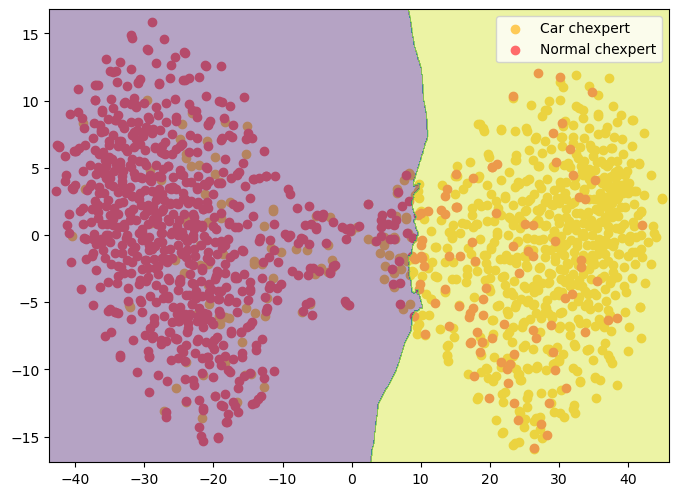

In [85]:
fig = plt.figure(figsize=[8,6],dpi=100)
ax = fig.add_subplot(111)

for label in colors_per_class:    

    indices_c = [i for i, l in enumerate(labels_chexpert[:t]) if l == label]
    current_tx_c = np.take(tx_c, indices_c)
    current_ty_c = np.take(ty_c, indices_c)
    color_c = np.array(colors_per_class[label][0], dtype=np.float) / 255
    ax.scatter(current_tx_c, current_ty_c, c=color_c, label=label_convert[label]+' chexpert',marker='o')
    
#     indices_m = [i for i, l in enumerate(labels_mimic[:t]) if l == label]
#     current_tx_m = np.take(tx_m, indices_m)
#     current_ty_m = np.take(ty_m, indices_m)
#     color_m = np.array(colors_per_class[label][1], dtype=np.float) / 255
#     ax.scatter(current_tx_m, current_ty_m, c=color_m, label=label_convert[label]+' mimic',marker='v')
    
#     indices_co = [i for i, l in enumerate(real[:t]) if l == label]
#     current_tx_co = np.take(tx_co, indices_co)
#     current_ty_co = np.take(ty_co, indices_co)
#     color_co = np.array(colors_per_class[label][2], dtype=np.float) / 255
#     ax.scatter(current_tx_co, current_ty_co, c=color_co, label=label_convert[label]+' converted',marker='x')
    
ax.contourf(xx, yy, Z, alpha=0.4)

ax.legend(loc='best')
plt.show()

In [ ]:
tx_m,ty_m = getxy(features_mimic)

from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=7)

# x1 = np.append(tx_m,tx_c)
# x2 = np.append(ty_m,ty_c)
# y = np.append(preds_mimic[:n],preds_chexpert[:n]).astype(int)

# x1 = tx_m
# x2 = ty_m
# y = np.array(preds_mimic[:n]).astype(int)

x1 = tx_m
x2 = ty_m
y = np.array(preds_mimic).astype(int)

X = np.column_stack((x1,x2))

clf.fit(X,y)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
for label in colors_per_class:
    
#     indices_c = [i for i, l in enumerate(labels_chexpert[:n]) if l == label]
#     current_tx_c = np.take(tx_c, indices_c)
#     current_ty_c = np.take(ty_c, indices_c)
#     color_c = np.array(colors_per_class[label][0], dtype=np.float) / 255
#     ax.scatter(current_tx_c, current_ty_c, c=color_c, label=label_convert[label]+' chexpert',marker='o')
    
    indices_m = [i for i, l in enumerate(labels_mimic) if l == label]
    current_tx_m = np.take(tx_m, indices_m)
    current_ty_m = np.take(ty_m, indices_m)
    color_m = np.array(colors_per_class[label][1], dtype=np.float) / 255
    ax.scatter(current_tx_m, current_ty_m, c=color_m, label=label_convert[label]+' mimic',marker='v')
    
ax.contourf(xx, yy, Z, alpha=0.4)

ax.legend(loc='best')
plt.show()